In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Markdown, display

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler


import time

In [2]:
start_time_total = time.time()

use_sample = False

df_cardio = pd.read_csv(
    "cardio_train.csv",
    sep=";",
    index_col="id",
)

if use_sample:
    sample_fraction = 0.01

    df_cardio = df_cardio.sample(frac=sample_fraction, random_state=42)

In [3]:
# Mapping some of the columns to more readable names
df_cardio.rename(
    columns={
        "cardio": "has_cardio_disease",
        "weight": "weight_kg",
        "height": "height_cm",
        "age": "age_in_days",
    },
    inplace=True,
)

df_cardio.columns

Index(['age_in_days', 'gender', 'height_cm', 'weight_kg', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'has_cardio_disease'],
      dtype='object')

In [4]:
df_cardio.head(10)

,age_in_days,gender,height_cm,weight_kg,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,has_cardio_disease
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
8,21914,1,151,67.0,120,80,2,2,0,0,0,0
9,22113,1,157,93.0,130,80,3,1,0,0,1,0
12,22584,2,178,95.0,130,90,3,3,0,0,1,1
13,17668,1,158,71.0,110,70,1,1,0,0,1,0


## EDA

#### • Hur många är positiva för hjärt-kärlsjukdom och hur många är negativa?

In [5]:
summary = df_cardio["has_cardio_disease"].value_counts()
negative, positive = summary
df_cardio["has_cardio_disease"].value_counts()
print(f"{negative} har INTE hjärt-kärlsjukdom (negative).")
print(f"{positive} har hjärt-kärlsjukdom (positive).")

35021 har INTE hjärt-kärlsjukdom (negative).
34979 har hjärt-kärlsjukdom (positive).


#### • Hur stor andel har normala, över normala och långt över normala koles-terolvärden? Rita ett tårtdiagram.

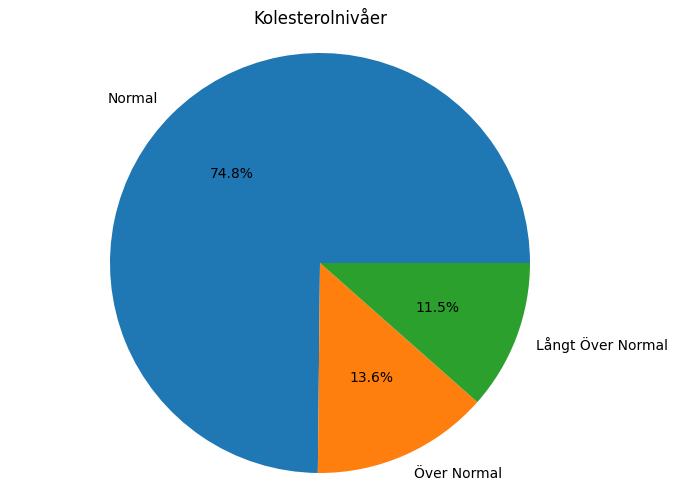

In [6]:
labels = ["Normal", "Över Normal", "Långt Över Normal"]

plt.figure(figsize=(8, 6))
plt.pie(
    df_cardio["cholesterol"].value_counts(),
    labels=labels,
    autopct="%1.1f%%",
)

plt.axis("equal")
plt.title("Kolesterolnivåer")
plt.show()

#### • Hur ser åldersfördelningen ut? Rita ett histogram.

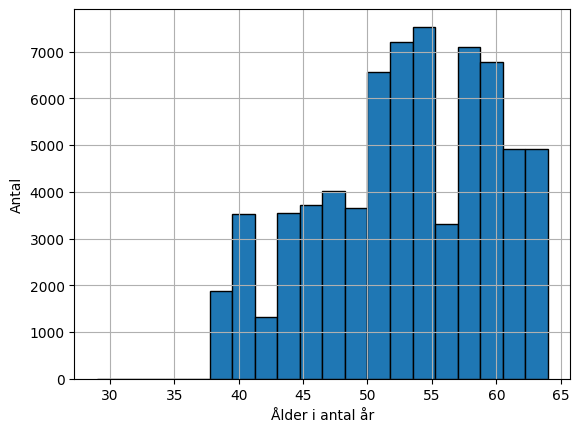

In [7]:
def days_to_years(days):
    years = days // 365.25
    return years


df_ages = df_cardio["age_in_days"].apply(days_to_years)

plt.hist(
    df_ages,
    bins=20,
    edgecolor="black",
)

plt.xlabel("Ålder i antal år")
plt.ylabel("Antal")
plt.grid(True)
plt.show()

#### • Hur stor andel röker?

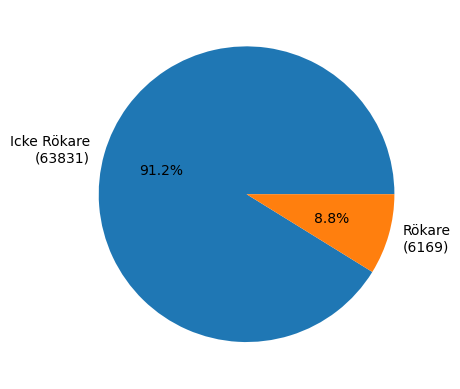

Totalt är det 70000 värden.
Andel icke-rökare: 63831/70000 = 91.19%
Andel rökare: 6169/70000 = 8.81%


In [8]:
# Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
summary = df_cardio["smoke"].value_counts()
non_smokers, smokers = summary
total = non_smokers + smokers

text_list = [f"Icke Rökare\n({non_smokers})", f"Rökare\n({smokers})"]

plt.pie(
    summary,
    labels=text_list,
    autopct="%1.1f%%",
)
plt.show()

print(f"Totalt är det {total} värden.")
print(f"Andel icke-rökare: {non_smokers}/{total} = {(non_smokers / total):.2%}")
print(f"Andel rökare: {smokers}/{total} = {(smokers / total):.2%}")

#### • Hur ser viktfördelningen ut? Rita lämpligt diagram.

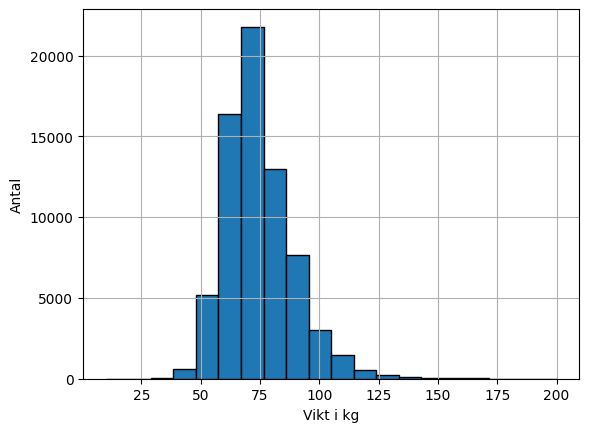

In [9]:
df_weights = df_cardio["weight_kg"]

plt.hist(
    df_weights,
    bins=20,
    edgecolor="black",
)

plt.xlabel("Vikt i kg")
plt.ylabel("Antal")
plt.grid(True)
plt.show()

#### • Hur ser längdfördelningen ut? Rita lämpligt diagram.

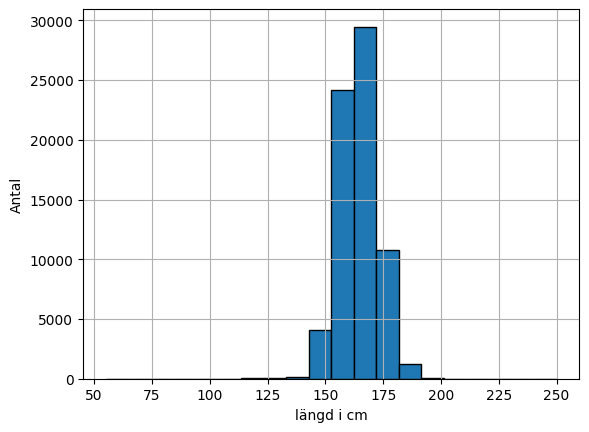

In [10]:
df_heights = df_cardio["height_cm"]

plt.hist(
    df_heights,
    bins=20,
    edgecolor="black",
)

plt.xlabel("längd i cm")
plt.ylabel("Antal")
plt.grid(True)
plt.show()

#### • Hur stor andel av kvinnor respektive män har hjärt-kärlsjukdom? Rita lämpligt diagram

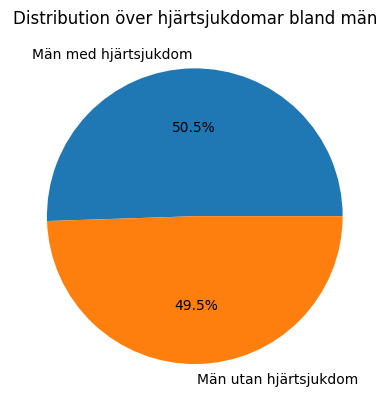

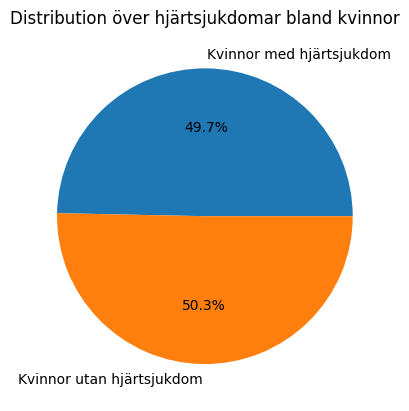

In [11]:
men = df_cardio[df_cardio["gender"] == 2]
women = df_cardio[df_cardio["gender"] == 1]

men_with_heart_disease = men[men["has_cardio_disease"] == 1].shape[0]
men_without_heart_disease = men[men["has_cardio_disease"] == 0].shape[0]

women_with_heart_disease = women[women["has_cardio_disease"] == 1].shape[0]
women_without_heart_disease = women[women["has_cardio_disease"] == 0].shape[0]


labels_men = ["Män med hjärtsjukdom", "Män utan hjärtsjukdom"]
sizes_men = [men_with_heart_disease, men_without_heart_disease]
plt.pie(
    sizes_men,
    labels=labels_men,
    autopct="%1.1f%%",
)
plt.title("Distribution över hjärtsjukdomar bland män")
plt.show()


labels_women = ["Kvinnor med hjärtsjukdom", "Kvinnor utan hjärtsjukdom"]
sizes_women = [women_with_heart_disease, women_without_heart_disease]
plt.pie(
    sizes_women,
    labels=labels_women,
    autopct="%1.1f%%",
)
plt.title("Distribution över hjärtsjukdomar bland kvinnor")
plt.show()

## Feature engineering BMI

In [12]:
def show_correlation_heat_map(df, k=0):

    correlation_matrix = df.corr()

    # Triangular matrix for correlation
    mask = np.triu(correlation_matrix, k)

    plt.figure(figsize=(12, 9))
    sns.heatmap(
        correlation_matrix,
        mask=mask,
        cmap="coolwarm",
        annot=True,
        linewidths=1,
        vmin=-1,
        vmax=1,
    )
    plt.title("Korrelationskarta")
    plt.show()

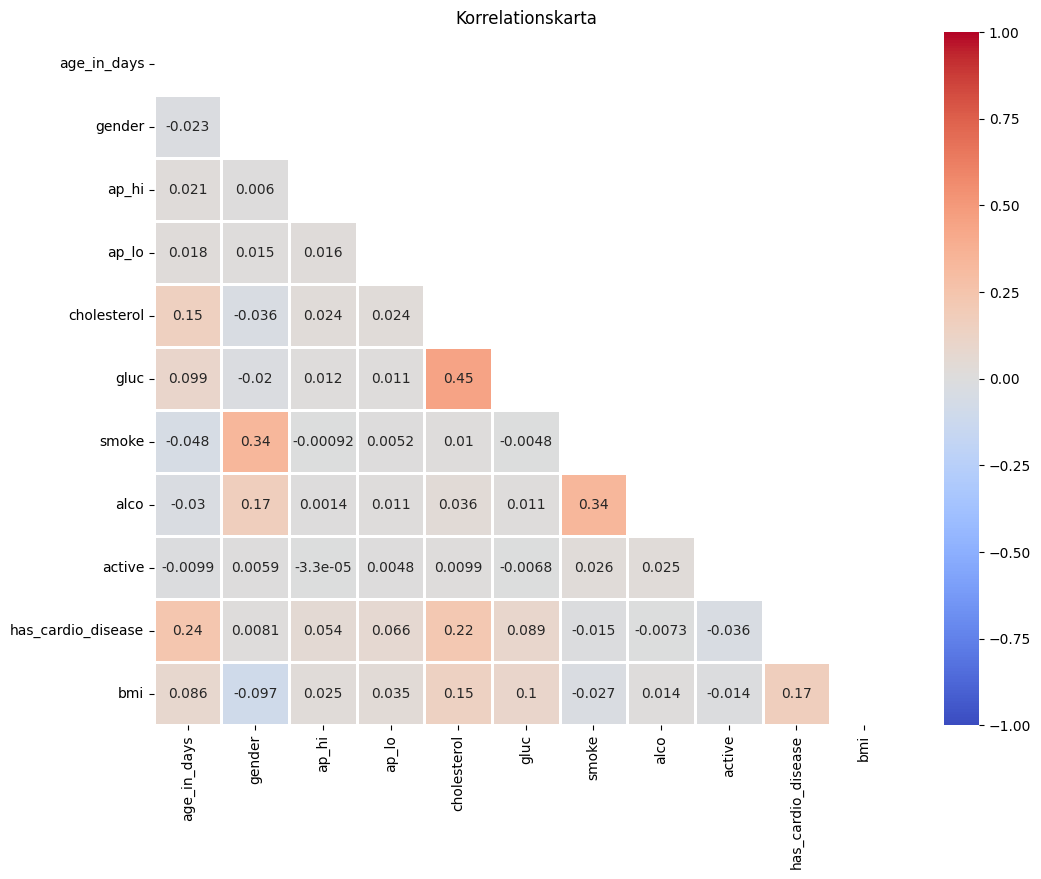

In [13]:
def bmi(weight_kg, height_cm):
    """Note that the dataset measures in cm"""
    return weight_kg / np.square(height_cm / 100)


df_cardio["bmi"] = bmi(
    df_cardio["weight_kg"],
    df_cardio["height_cm"],
)

df_cardio.drop(
    columns=[
        "weight_kg",
        "height_cm",
    ],
    inplace=True,
)

show_correlation_heat_map(df_cardio)

#### • Skapa en kategorisk BMI-feature med kategorierna: normal range, over-weight, obese (class I), obese (class II), obese (class III).
#### • Släng de samples med orimliga BMIer och outliers. Notera att detta kan vara svårt att<br>avgöra i vilket range av BMIer som vi ska spara. Beskriv hur du kommer fram till gränserna.

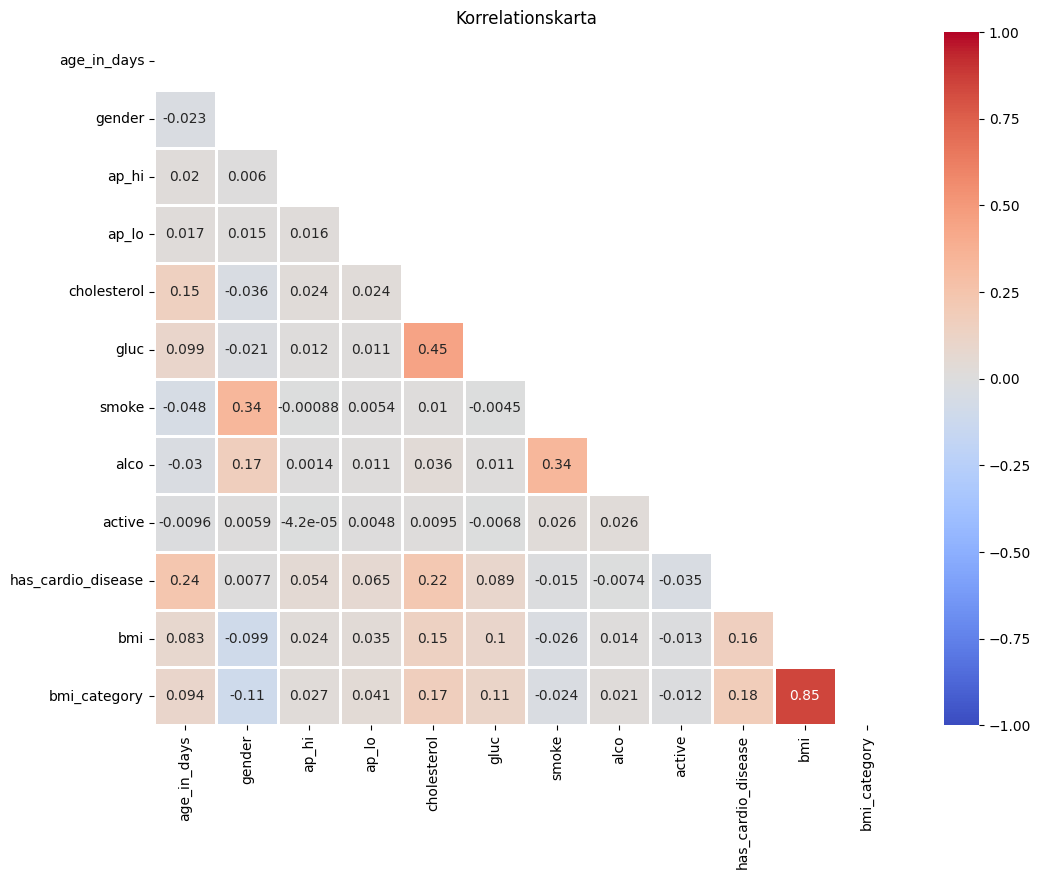

In [14]:
def bmi_classifier(bmi_value):
    """
    Values based on this article:
    https://en.wikipedia.org/wiki/Body_mass_index#Categories
    """

    out_of_bounds_bmi = -1  # Abnormal value

    if bmi_value < 18.5:
        return out_of_bounds_bmi
    elif 18.5 <= bmi_value < 25.0:
        return 1  # "Normal weight"
    elif 25.0 <= bmi_value < 30.0:
        return 2  # "Overweight"
    elif 30.0 <= bmi_value < 35.0:
        return 3  # "Obese (Class I)"
    elif 35.0 <= bmi_value < 40.0:
        return 4  # "Obese (Class II)"
    elif bmi_value >= 40.0:
        return 5  # "Obese (Class III)"
    else:
        return out_of_bounds_bmi


df_cardio["bmi_category"] = df_cardio["bmi"].apply(bmi_classifier).astype("category")
df_cardio = df_cardio[df_cardio["bmi_category"] != -1]

df_cardio["bmi_category"]
show_correlation_heat_map(df_cardio)

## Feature engineering blodtryck

### • Släng bort samples med orimliga blodtryck och outliers. Likt förra uppgiften är det inte trivialt att sätta gränserna.<br>Skapa en feature för blodtryckskategorier enligt tabellen i denna artikel:<br>https://www.healthline.com/health/high-blood-pressure-hypertensiondefinition.<br>Beskriv hur du kommer fram till gränserna.

In [15]:
def blood_pressure_category(systolic, diastolic):
    if (systolic < 120) and (diastolic < 80):
        return 1  # Healty
    elif (120 <= systolic < 130) and (diastolic < 80):
        return 2  # Elevated
    elif (130 <= systolic < 140) or (80 <= diastolic < 90):
        return 3  # Stage 1 Hypertension
    elif (systolic >= 140) or (diastolic >= 90):
        return 4  # Stage 2 Hypertension
    elif (systolic > 180) or (diastolic > 120):
        return 5  # Hypertension Crisis
    else:
        return -1  # ABNORMAL


def apply_function(df):
    return blood_pressure_category(df["ap_hi"], df["ap_lo"])


df_cardio["blood_pressure_category"] = df_cardio.apply(apply_function, axis=1).astype(
    "category"
)
df_cardio = df_cardio[df_cardio["blood_pressure_category"] != -1]

## Visualiseringar andel sjukdomar

### Skapa barplots med en feature mot andelen positiva för hjärt-kärl sjukdom.<br>Exempelvis blodtryckskategorier mot andel positiva, BMI<br>kategori mot andel positiva mm. Gör dessa plots i en figur med flera subplots.

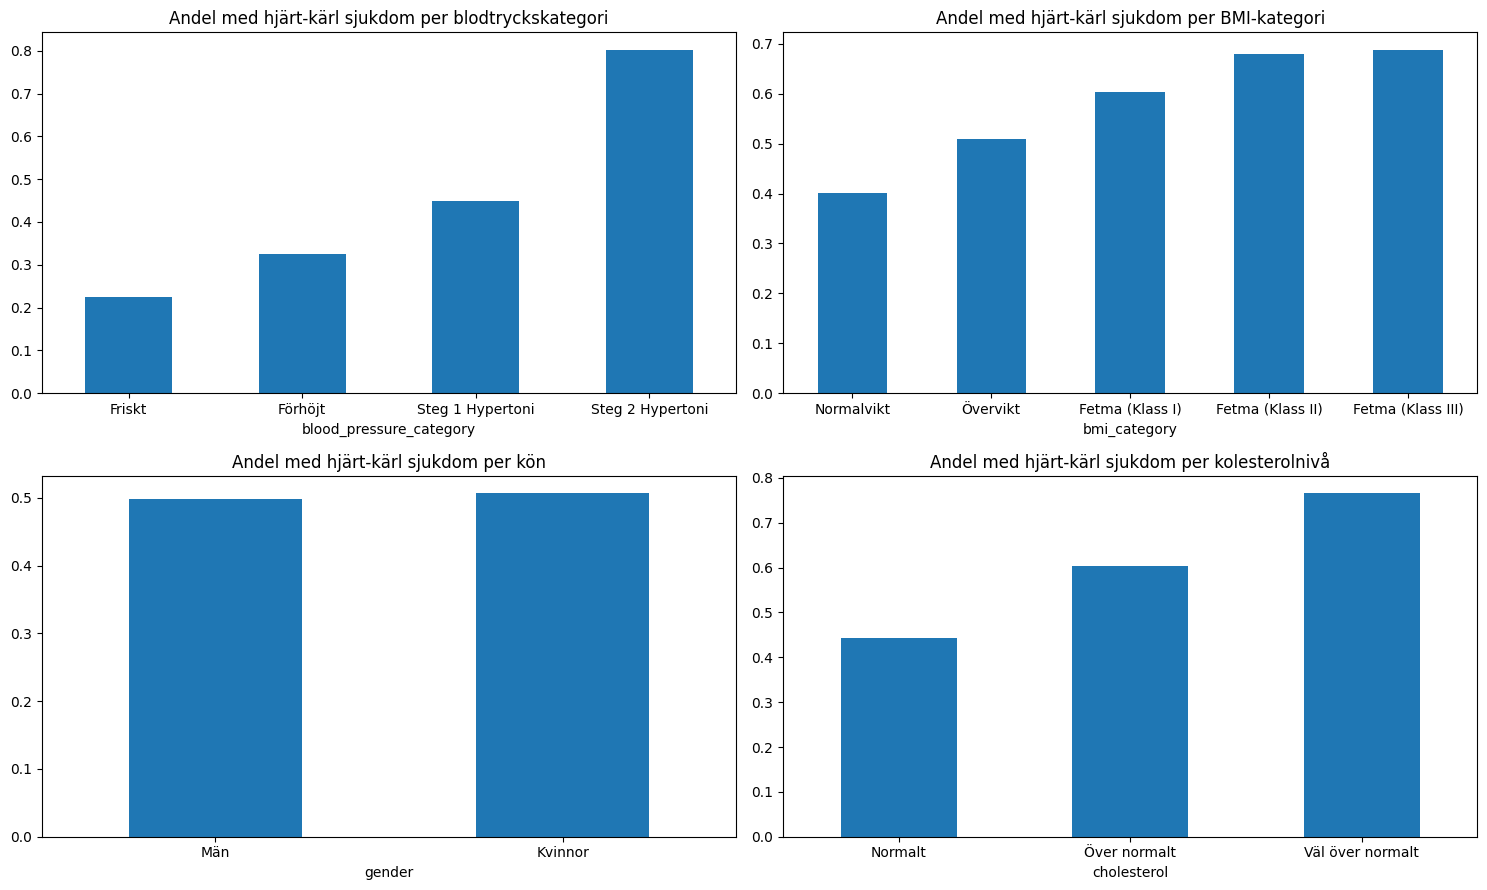

In [16]:
blood_pressure_mapping = {
    1: "Friskt",
    2: "Förhöjt",
    3: "Steg 1 Hypertoni",
    4: "Steg 2 Hypertoni",
    5: "Hypertonikris",
    # -1: "Abnormalt",
}

bmi_mapping = {
    1: "Normalvikt",
    2: "Övervikt",
    3: "Fetma (Klass I)",
    4: "Fetma (Klass II)",
    5: "Fetma (Klass III)",
    # -1: "Utanför gränserna",
}

gender_mapping = {1: "Män", 2: "Kvinnor"}

cholesterol_mapping = {1: "Normalt", 2: "Över normalt", 3: "Väl över normalt"}

plt.figure(figsize=(15, 9))

plt.subplot(2, 2, 1)
bp_data = df_cardio.groupby("blood_pressure_category", observed=True)[
    "has_cardio_disease"
].mean()
bp_data.plot(kind="bar")
plt.title("Andel med hjärt-kärl sjukdom per blodtryckskategori")
plt.xticks(
    ticks=range(len(bp_data)),
    labels=(blood_pressure_mapping[x] for x in bp_data.index),
    rotation=0,
)
plt.yticks(rotation=0)

plt.subplot(2, 2, 2)
bmi_data = df_cardio.groupby("bmi_category", observed=True)["has_cardio_disease"].mean()
bmi_data.plot(kind="bar")
plt.title("Andel med hjärt-kärl sjukdom per BMI-kategori")
plt.xticks(
    ticks=range(len(bmi_data)),
    labels=(bmi_mapping[x] for x in bmi_data.index),
    rotation=0,
)
plt.yticks(rotation=0)

plt.subplot(2, 2, 3)
gender_data = df_cardio.groupby("gender", observed=True)["has_cardio_disease"].mean()
gender_data.plot(kind="bar")
plt.title("Andel med hjärt-kärl sjukdom per kön")
plt.xticks(
    ticks=range(len(gender_data)),
    labels=(gender_mapping[x] for x in gender_data.index),
    rotation=0,
)
plt.yticks(rotation=0)

plt.subplot(2, 2, 4)
chol_data = df_cardio.groupby("cholesterol", observed=True)["has_cardio_disease"].mean()
chol_data.plot(kind="bar")
plt.title("Andel med hjärt-kärl sjukdom per kolesterolnivå")
plt.xticks(
    ticks=range(len(chol_data)),
    labels=(cholesterol_mapping[x] for x in chol_data.index),
    rotation=0,
)
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

## Visualiseringar korrelation

### Heatmap av korrelationer

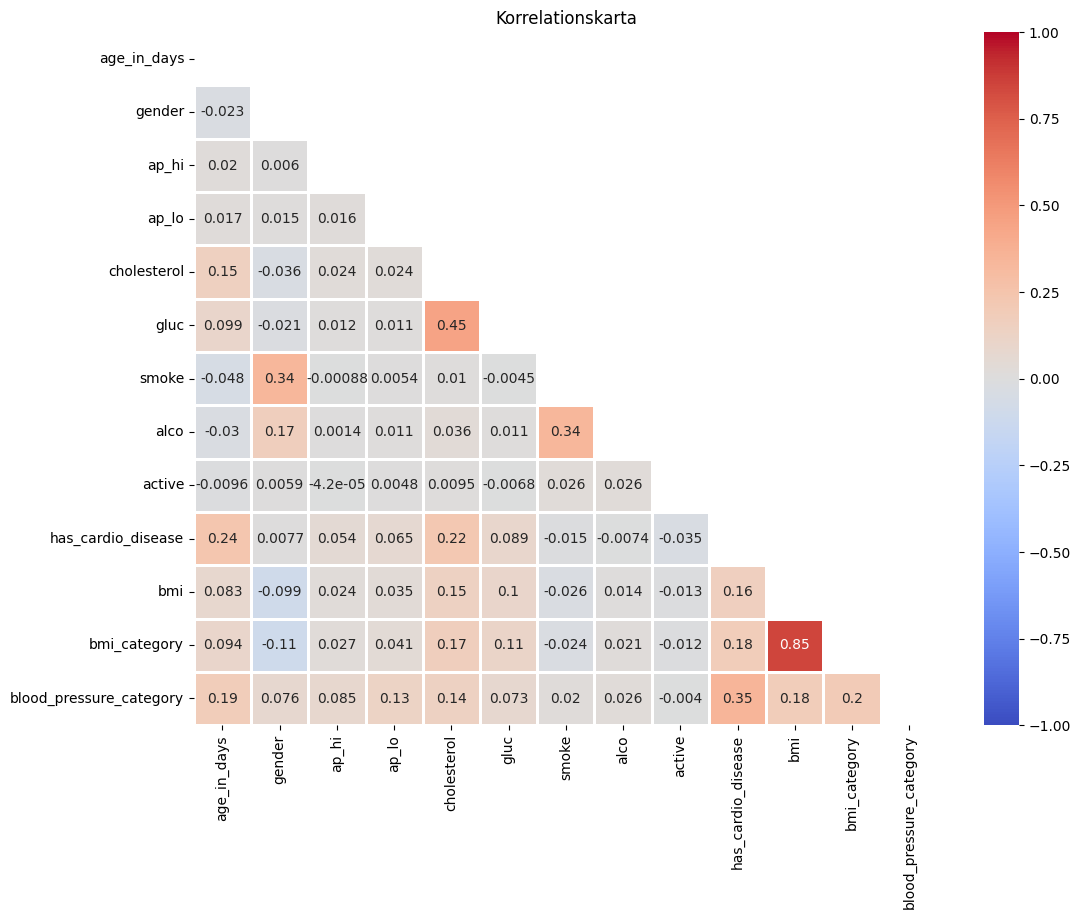

[]

In [17]:
show_correlation_heat_map(df_cardio)
!!!

## Skapa två dataset

### • Dataset 1: Ta bort följande features: ap hi, ap lo, height, weight, BMI<br>• Gör one-hot encoding på BMI-kategori, blodtryckskategori och kön

In [18]:
df_cardio_copy1 = df_cardio.copy()

df_cardio_copy1.drop(
    columns=[
        "ap_hi",
        "ap_lo",
        #"height_cm",
        #"weight_kg",
        "bmi",
    ],
    inplace=True,
)
df_cardio_copy1 = pd.get_dummies(
    df_cardio_copy1, columns=["gender", "bmi_category", "blood_pressure_category"]
).astype(int)
df_cardio_copy1.drop(columns=["bmi_category_-1"], inplace=True)
df_cardio_copy1

,age_in_days,cholesterol,gluc,smoke,alco,active,has_cardio_disease,gender_1,gender_2,bmi_category_1,bmi_category_2,bmi_category_3,bmi_category_4,bmi_category_5,blood_pressure_category_1,blood_pressure_category_2,blood_pressure_category_3,blood_pressure_category_4
id,,,,,,,,,,,,,,,,,,
0,18393,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0
1,20228,3,1,0,0,1,1,1,0,0,0,1,0,0,0,0,0,1
2,18857,3,1,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0
3,17623,1,1,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1
4,17474,1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,1,1,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0
99995,22601,2,2,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1
99996,19066,3,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1


### • Dataset 2: Ta bort följande features: BMI-kategori, blodtryckskategori, height, weight<br>• Gör one-hot encoding på kön

In [19]:
df_cardio_copy2 = df_cardio.copy()

df_cardio_copy2.drop(
    columns=[
        "bmi_category",
        "blood_pressure_category",
        #"height_cm",
        #"weight_kg",
    ],
    inplace=True,
)
df_cardio_copy2 = pd.get_dummies(df_cardio_copy2, columns=["gender"]).astype(int)
df_cardio_copy2

,age_in_days,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,has_cardio_disease,bmi,gender_1,gender_2
id,,,,,,,,,,,,
0,18393,110,80,1,1,0,0,1,0,21,0,1
1,20228,140,90,3,1,0,0,1,1,34,1,0
2,18857,130,70,3,1,0,0,0,1,23,1,0
3,17623,150,100,1,1,0,0,1,1,28,0,1
4,17474,100,60,1,1,0,0,0,0,23,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,120,80,1,1,1,0,1,0,26,0,1
99995,22601,140,90,2,2,0,0,1,1,50,1,0
99996,19066,180,90,3,1,0,1,0,1,31,0,1


In [20]:
df_cardio

,age_in_days,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,has_cardio_disease,bmi,bmi_category,blood_pressure_category
id,,,,,,,,,,,,,
0,18393,2,110,80,1,1,0,0,1,0,21.967120,1,3
1,20228,1,140,90,3,1,0,0,1,1,34.927679,3,4
2,18857,1,130,70,3,1,0,0,0,1,23.507805,1,3
3,17623,2,150,100,1,1,0,0,1,1,28.710479,2,4
4,17474,1,100,60,1,1,0,0,0,0,23.011177,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,2,120,80,1,1,1,0,1,0,26.927438,2,3
99995,22601,1,140,90,2,2,0,0,1,1,50.472681,5,4
99996,19066,2,180,90,3,1,0,1,0,1,31.353579,3,4


In [21]:
data_frames = {
    "Dataset_1_Categorical": df_cardio_copy1,
    "Dataset_2_NumericalBMI": df_cardio_copy2,
}

models_and_params = {
    "LogisticRegression": {
        "model": LogisticRegression(
            random_state=42,
            max_iter=1000,
            class_weight="balanced",
        ),
        "params": {
            "C": [0.1, 1.0, 10.0],
            "solver": ["liblinear"],
        },
    },
    "RandomForest": {
        "model": RandomForestClassifier(
            random_state=42,
            class_weight="balanced",
        ),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [10, 20],
            "min_samples_split": [5, 10],
        },
    },
    "GaussianNB": {
        "model": GaussianNB(),
        "params": {
            "var_smoothing": [1e-9, 1e-8, 1e-7],
        },
    },
}

scalers = {
    "Standardization": StandardScaler(),
    "Normalization": MinMaxScaler(),
}

results = {}

### Träning och Validering av Modeller

In [22]:

for df_name, df in data_frames.items():
    print(f"Bearbetar {df_name}")
    results[df_name] = {}

    X = df.drop("has_cardio_disease", axis=1)
    y = df["has_cardio_disease"]

    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val,
        y_train_val,
        test_size=0.25,
        random_state=42,
        stratify=y_train_val,
    )

    for scaler_name, scaler in scalers.items():
        print()
        print(f"Skalning: {scaler_name}")
        results[df_name][scaler_name] = {}

        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        for model_name, model_info in models_and_params.items():
            start_time = time.time()
            print()
            print(f"Tränar {model_name} ...")

            grid_search = GridSearchCV(
                estimator=model_info["model"],
                param_grid=model_info["params"],
                scoring="f1",
                cv=5,
                n_jobs=-1,
                verbose=3,
            )

            grid_search.fit(X_train_scaled, y_train)
            end_time = time.time()

            best_model = grid_search.best_estimator_
            best_params = grid_search.best_params_
            best_cv_score = grid_search.best_score_

            y_val_pred = best_model.predict(X_val_scaled)

            val_f1 = f1_score(y_val, y_val_pred)
            val_accuracy = accuracy_score(y_val, y_val_pred)

            results[df_name][scaler_name][model_name] = {
                "best_params": best_params,
                "best_cv_f1_score": best_cv_score,
                "validation_f1_score": val_f1,
                "validation_accuracy": val_accuracy,
                "training_time_seconds": end_time - start_time,
            }

            print(f"Bästa parametrar för {model_name}: {best_params}")
            print(
                f"Bästa F1-score (medelvärde från CV på träningsdata): {best_cv_score:.4f}"
            )
            print(f"F1-score på valideringsdata: {val_f1:.4f}")
            print(f"Accuracy på valideringsdata: {val_accuracy:.4f}")
            print(f"Träningstid: {end_time - start_time:.2f} sekunder")
            print()

Bearbetar Dataset_1_Categorical

Skalning: Standardization

Tränar LogisticRegression ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 2/5] END ...........C=0.1, solver=liblinear;, score=0.683 total time=   0.1s
[CV 3/5] END ...........C=0.1, solver=liblinear;, score=0.694 total time=   0.1s
[CV 5/5] END ...........C=0.1, solver=liblinear;, score=0.685 total time=   0.1s
[CV 1/5] END ...........C=1.0, solver=liblinear;, score=0.672 total time=   0.1s
[CV 2/5] END ...........C=1.0, solver=liblinear;, score=0.684 total time=   0.1s
[CV 4/5] END ...........C=1.0, solver=liblinear;, score=0.676 total time=   0.1s
[CV 3/5] END ...........C=1.0, solver=liblinear;, score=0.694 total time=   0.1s
[CV 1/5] END ...........C=0.1, solver=liblinear;, score=0.672 total time=   0.1s
[CV 5/5] END ...........C=1.0, solver=liblinear;, score=0.685 total time=   0.1s
[CV 1/5] END ..........C=10.0, solver=liblinear;, score=0.672 total time=   0.1s
[CV 2/5] END ..........C=10.0, solver=li

## Sammanfattning

In [23]:

print("Sammanfattning av Resultat")
print()

summary_list = []
for df_name, df_results in results.items():
    for scaler_name, scaler_results in df_results.items():
        for model_name, model_results in scaler_results.items():
            summary_list.append(
                {
                    "Dataset": df_name,
                    "Model": model_name,
                    "Scaler": scaler_name,
                    "Best CV F1": model_results["best_cv_f1_score"],
                    "Validation F1": model_results["validation_f1_score"],
                    "Validation Accuracy": model_results["validation_accuracy"],
                    "Best Params": model_results["best_params"],
                    "Time in seconds": model_results["training_time_seconds"],
                }
            )

summary_df = pd.DataFrame(summary_list)

summary_df.sort_values(by=["Dataset", "Model", "Scaler"], inplace=True)


display(Markdown(summary_df.to_markdown(index=False)))

Sammanfattning av Resultat



| Dataset                | Model              | Scaler          |   Best CV F1 |   Validation F1 |   Validation Accuracy | Best Params                                                     |   Time in seconds |
|:-----------------------|:-------------------|:----------------|-------------:|----------------:|----------------------:|:----------------------------------------------------------------|------------------:|
| Dataset_1_Categorical  | GaussianNB         | Normalization   |     0.664544 |        0.656751 |              0.682192 | {'var_smoothing': 1e-09}                                        |          0.318001 |
| Dataset_1_Categorical  | GaussianNB         | Standardization |     0.664544 |        0.656751 |              0.682192 | {'var_smoothing': 1e-09}                                        |          0.290202 |
| Dataset_1_Categorical  | LogisticRegression | Normalization   |     0.682164 |        0.679569 |              0.697981 | {'C': 1.0, 'solver': 'liblinear'}                               |          0.620224 |
| Dataset_1_Categorical  | LogisticRegression | Standardization |     0.682125 |        0.680122 |              0.698342 | {'C': 1.0, 'solver': 'liblinear'}                               |          2.6868   |
| Dataset_1_Categorical  | RandomForest       | Normalization   |     0.687714 |        0.68488  |              0.698125 | {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200} |         52.6315   |
| Dataset_1_Categorical  | RandomForest       | Standardization |     0.687647 |        0.684781 |              0.698053 | {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200} |         54.4301   |
| Dataset_2_NumericalBMI | GaussianNB         | Normalization   |     0.393846 |        0.383028 |              0.579596 | {'var_smoothing': 1e-09}                                        |          0.250379 |
| Dataset_2_NumericalBMI | GaussianNB         | Standardization |     0.393846 |        0.383028 |              0.579596 | {'var_smoothing': 1e-09}                                        |          0.250786 |
| Dataset_2_NumericalBMI | LogisticRegression | Normalization   |     0.645176 |        0.641759 |              0.652271 | {'C': 10.0, 'solver': 'liblinear'}                              |          1.17806  |
| Dataset_2_NumericalBMI | LogisticRegression | Standardization |     0.708688 |        0.704075 |              0.716727 | {'C': 10.0, 'solver': 'liblinear'}                              |          1.82483  |
| Dataset_2_NumericalBMI | RandomForest       | Normalization   |     0.721834 |        0.718158 |              0.731651 | {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}  |         56.2309   |
| Dataset_2_NumericalBMI | RandomForest       | Standardization |     0.721991 |        0.717953 |              0.731435 | {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}  |         55.0405   |


Ensemble
Valt dataset: Dataset_2_NumericalBMI
Vald skalare: Normalization

Bästa parametrar:
Logistic Regression: {'C': 10.0, 'solver': 'liblinear'}
Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
GaussianNB: {'var_smoothing': 1e-09}

Tränar ensemblemodellen på 55480 datapunkter.
Testar på 13870 datapunkter.

Tid: 3.42 sekunder.

Evaluering av Test Set


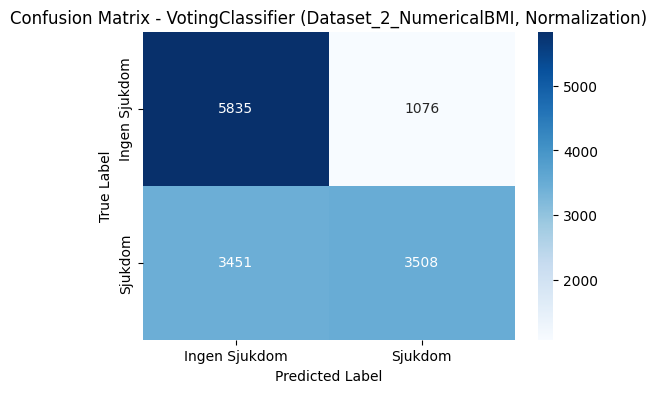


Classification Report:
                   precision    recall  f1-score   support

Ingen Sjukdom (0)       0.63      0.84      0.72      6911
      Sjukdom (1)       0.77      0.50      0.61      6959

         accuracy                           0.67     13870
        macro avg       0.70      0.67      0.66     13870
     weighted avg       0.70      0.67      0.66     13870



In [24]:
chosen_dataset_name = "Dataset_2_NumericalBMI"
chosen_scaler_name = "Normalization"

print()
print(f"Ensemble")
print(f"Valt dataset: {chosen_dataset_name}")
print(f"Vald skalare: {chosen_scaler_name}")

best_lr_params = results[chosen_dataset_name][chosen_scaler_name]["LogisticRegression"][
    "best_params"
]
best_rf_params = results[chosen_dataset_name][chosen_scaler_name]["RandomForest"][
    "best_params"
]
best_gnb_params = results[chosen_dataset_name][chosen_scaler_name]["GaussianNB"][
    "best_params"
]

print()
print(f"Bästa parametrar:")
print(f"Logistic Regression: {best_lr_params}")
print(f"Random Forest: {best_rf_params}")
print(f"GaussianNB: {best_gnb_params}")


df_chosen = data_frames[chosen_dataset_name]
X = df_chosen.drop("has_cardio_disease", axis=1)
y = df_chosen["has_cardio_disease"]

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler_ensemble = scalers[chosen_scaler_name]
X_train_val_scaled = scaler_ensemble.fit_transform(X_train_val)
X_test_scaled = scaler_ensemble.transform(X_test)

print()
print(f"Tränar ensemblemodellen på {X_train_val_scaled.shape[0]} datapunkter.")
print(f"Testar på {X_test_scaled.shape[0]} datapunkter.")

logistic_regression = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight="balanced",
    **best_lr_params,
)
random_forest_classifier = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    **best_rf_params,
)
gnb = GaussianNB(
    **best_gnb_params,
)

voting_classifier = VotingClassifier(
    estimators=[
        ("lr", logistic_regression),
        ("rf", random_forest_classifier),
        ("gnb", gnb),
    ],
    voting="soft",
)

start_time_ensemble = time.time()
voting_classifier.fit(X_train_val_scaled, y_train_val)
end_time_ensemble = time.time()

print()
print(f"Tid: {end_time_ensemble - start_time_ensemble:.2f} sekunder.")

print()
print(f"Evaluering av Test Set")

y_test_pred = voting_classifier.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Ingen Sjukdom", "Sjukdom"],
    yticklabels=["Ingen Sjukdom", "Sjukdom"],
)
plt.title(
    f"Confusion Matrix - VotingClassifier ({chosen_dataset_name}, {chosen_scaler_name})"
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


report = classification_report(
    y_test, y_test_pred, target_names=["Ingen Sjukdom (0)", "Sjukdom (1)"]
)

print()
print("Classification Report:")
print(report)

In [25]:
end_time_total = time.time()
total_duration_seconds = end_time_total - start_time_total

total_seconds_int = int(total_duration_seconds)
minutes_total, seconds = divmod(total_seconds_int, 60)
hours, minutes = divmod(minutes_total, 60)

second_string = "Sekund" if minutes == 1 else "Sekunder"
minute_string = "Minut" if minutes == 1 else "Minuter"
hour_string = "Timme" if minutes == 1 else "Timmar"

print(f"Total körningstid:")
print(f"Totalt antal sekunder: {total_duration_seconds:.2f}")
print(
    f"{hours} {hour_string}, {minutes} {minute_string}, och {seconds} {second_string}"
)

Total körningstid:
Totalt antal sekunder: 233.92
0 Timmar, 3 Minuter, och 53 Sekunder
